# Libraries

In [134]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import time
import os
import datetime
import pytz
import random

In [135]:
from sklearn.model_selection import train_test_split

In [136]:
import torchvision.models as models
from torchvision.models import resnet34, ResNet34_Weights
from torchvision import models

In [137]:
import torch
from PIL import Image
import torchvision
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable

In [138]:
from torchvision import datasets,transforms
from torch.utils.data import DataLoader
from torch.utils.data import DataLoader, Dataset,random_split
from skimage import io, transform
import torchvision.transforms as transforms
from torchvision import transforms, utils
from torchvision.datasets import ImageFolder

In [139]:
import torch.nn as nn
import torch.optim as optim

In [140]:
# Ignore warnings
import warnings
warnings.filterwarnings("ignore")

plt.ion()   # interactive mode

In [141]:
tzInfo = pytz.timezone('Asia/Kolkata')
dt = str(datetime.datetime.now(tz=tzInfo))

In [142]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(device)

cuda:0


In [143]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## Paths

In [144]:
result_PATH = "/content/drive/MyDrive/Drive f20190077/4-2/0_Split/results_cut.csv"
csv_PATH = "/content/drive/MyDrive/Drive f20190077/4-2/0_Split/DR/trainLabels_Binary.csv"
class_PATH = "/content/drive/MyDrive/Drive f20190077/4-2/0_Split/DR/resized_train_cropped/Classes2/"
images_PATH = "/content/drive/MyDrive/Drive f20190077/4-2/0_Split/DR/resized_train_cropped/resized_train_cropped/"
model_PATH = '/content/drive/MyDrive/Drive f20190077/4-2/0_Split/Model_Weights/ResNet_S/' 

## Constants

In [145]:
results = {"Clients":[],	"Train_Images": [],	"Test_Images":[],	"Epochs":[],
        "Test_Accuracy":[], "Train_Time":[],	"Test_Time":[], "Datetime":[]}

results

{'Clients': [],
 'Train_Images': [],
 'Test_Images': [],
 'Epochs': [],
 'Test_Accuracy': [],
 'Train_Time': [],
 'Test_Time': [],
 'Datetime': []}

In [146]:
num_clients = 2
cut_layer = 7 # DO NOT USE CUT_LAYER = 1, IT GIVES A "Lead Variable can't be used for in-place operation" ERROR (at the line outputs =  server_model(server_inputs))
train_images = 1000
test_images = int(train_images/5)
epochs = 20
learning_rate = 0.001

In [147]:
print(train_images)

1000


## Transforms

In [148]:
import torchvision.transforms as transforms

c_trans = transforms.Compose([ # For ImageFolder
    transforms.Resize((224,224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]), 
])


d_trans = transforms.Compose([ # For the dataset class
    transforms.ToPILImage(), ## WE NEED THIS OR ELSE IT GIVES TYPE ERROR WITH NUMPY NDARRAY
    transforms.Resize((224,224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])


# Load Data, Normalize, Trainloader

## DF Split!

In [149]:
cropped_new_df = pd.read_csv(csv_PATH)
cropped_new_df.head()

,Unnamed: 0,image,level
0,0,10_left,0
1,1,10_right,0
2,2,13_left,0
3,3,13_right,0
4,5,15_right,1


In [150]:
len(cropped_new_df)

32670

In [151]:
cdf = cropped_new_df.copy()

In [152]:
len(cdf)

32670

### Old

In [153]:
cdf = cropped_new_df.copy()
y = cdf.pop('level').to_frame()
X = cdf

In [154]:
X_train, X_test, y_train, y_test = train_test_split(X, y,stratify=y, test_size=0.4) # Stratify = y, maintains the same proportion of zero:one as the original in the new sets too!

In [155]:
len(X_train)

19602

In [156]:
def count_nums(df):
  lis = [l for l in df["level"]]
  print("Total = ", len(lis))
  z, o = lis.count(0), lis.count(1)
  print(z, " zeroes and ", o, " ones")
  print("Zero : One Ratio is ", round(z/o, 4))
  print()

In [157]:
X["level"] = y["level"]
X_train["level"] = y_train["level"]
X_test["level"] = y_test["level"]

count_nums(X)
count_nums(X_train)
count_nums(X_test) # Stratify = y, maintains the same proportion of zero:one as the original in the new sets too!

Total =  32670
25802  zeroes and  6868  ones
Zero : One Ratio is  3.7568

Total =  19602
15481  zeroes and  4121  ones
Zero : One Ratio is  3.7566

Total =  13068
10321  zeroes and  2747  ones
Zero : One Ratio is  3.7572



## Dataset class!

In [158]:
class retinaDataset_New(Dataset):
    def __init__(self, imagepath = images_PATH, cdf_trest = None, transform = None):
        self.df = cropped_new_df
        
        if (cdf_trest is not None):
            self.df = cdf_trest
        
        self.transform = transform
        
        self.imagepath = imagepath
        
    def __len__(self):
        return len(self.df)
    
    def __getitem__(self, index):
        img_path = os.path.join(self.imagepath, self.df.iloc[index].image +".jpeg")
        # img = Image.open(img_path) # Old
        img = io.imread(img_path) # New
        img = torch.from_numpy(img).permute(2, 0, 1)
        
        if(self.transform):
            img = self.transform(img)
        
        return img, torch.tensor(self.df.iloc[index].level)

## Separate Datasets for each Client

In [159]:
def train_split_equal_binary(cdf, samples_n_train, samples_n_test): #samples_n per class

    see = random.randint(1, 18)
    # print(see)
    
    X_train, X_i, y_i = make_df(cdf, samples_n_train, see)

    # Remove the X_train elements from the overall list
    [X_i.remove(v) for v in X_train["image"]]
    [y_i.remove(w) for w in X_train["level"]]

    # This is so we can reshuffle the X_i and y_i after removing the 'X_train' elements
    cdf = pd.DataFrame()
    cdf["image"] = X_i
    cdf["level"] = y_i

    # print("After Train Set item removal")
    # print(" ",len(X_i), len(y_i))

    X_test, X_i, y_i = make_df(cdf, samples_n_test, see)


    return X_train, X_test, cdf # Returns DFs


def make_df(cdf, samples_n, seed): # Given the cropped df, shuffle it and make a df with equal zeroes and ones!
    indicesClass1 = []
    indicesClass2 = []

    cdf.sample(frac=1, random_state=seed)

    y_i = [x for x in cdf["level"]]
    X_i = [x for x in cdf["image"]]

    # print("Inside mdf")
    # print(" ",len(X_i), len(y_i))

    # Get Equal Zeros and Ones in X_indices
    for i in range(0, len(y_i)):
        if y_i[i] == 0 and len(indicesClass1) < samples_n:
            indicesClass1.append((X_i[i], y_i[i]))
        elif y_i[i] == 1 and len(indicesClass2) < samples_n:
            indicesClass2.append((X_i[i], y_i[i]))
            
        if len(indicesClass1) == samples_n and len(indicesClass2) == samples_n:
            break
    
    X_indices = indicesClass1 + indicesClass2
    X_trest = pd.DataFrame({"image":[], "level":[]})

    # Make it a df!
    X_trest["image"] = [a for a, b in X_indices]
    X_trest["level"] = [b for a, b in X_indices]

    return X_trest, X_i, y_i

In [160]:
def create_test_train_loaders(cdf, train_images = train_images, test_images = test_images, batch_size = 32):

  cdf_train, cdf_test, cdf = train_split_equal_binary(cdf, samples_n_train = int(train_images/2), samples_n_test = int(test_images/2))
  # print(len(cdf))
  # cdf_train_2, cdf_test_2, cdf = train_split_equal_binary(cdf, samples_n_train = int(train_images/2), samples_n_test = int(test_images/2))

  cdf_TR = cdf_train.copy() # Change this for testset too!
  class_counts = cdf_TR.level.value_counts()
  class_weights = 1/class_counts
  train_weights = [1/class_counts[i] for i in cdf_TR.level.values] # Need weights for each image!!! Sampler is class agnostic, operates on the image level!!

  cdf_TS = cdf_test.copy() # Change this for testset too!
  class_counts = cdf_TS.level.value_counts()
  class_weights = 1/class_counts
  test_weights = [1/class_counts[i] for i in cdf_TS.level.values] # Need weights for each image!!! Sampler is class agnostic, operates on the image level!!

  train_sampler = torch.utils.data.sampler.WeightedRandomSampler(train_weights, num_samples = train_images, replacement = True) # This just makes sure that each batch has equal 0s and 1s
  test_sampler = torch.utils.data.sampler.WeightedRandomSampler(test_weights, num_samples = test_images, replacement = True) # It does NOT balance the dataset!!

  trainset_DS = retinaDataset_New(cdf_trest = cdf_train, transform = d_trans)
  testset_DS = retinaDataset_New(cdf_trest = cdf_test, transform = d_trans) # Helps ensure that batches are also balanced!! (Dataset is already balanced by our previous functions!!)

  trainloader_DS = DataLoader(dataset=trainset_DS, batch_size = 32, sampler = train_sampler)
  testloader_DS = DataLoader(dataset=testset_DS, batch_size = 32, sampler = test_sampler)

  return cdf, cdf_train, cdf_test, trainloader_DS, testloader_DS

## Train and Testloaders

In [161]:
cdf = cropped_new_df.copy()

cdf_train_list = []
cdf_test_list = []

trainloaders = [[] for _ in range(num_clients)]
testloaders = [[] for _ in range(num_clients)]

for c in range(num_clients):
  cdf, cdf_train, cdf_test, trainloader_DS, testloader_DS = create_test_train_loaders(cdf, train_images = train_images, test_images = test_images, batch_size = 32)

  trainloaders[c] = trainloader_DS
  testloaders[c] = testloader_DS

  cdf_train_list.append(cdf_train)
  cdf_test_list.append(cdf_test)


In [162]:
print(cdf_train_list[0].head(20))

       image  level
0    10_left      0
1   10_right      0
2    13_left      0
3   13_right      0
4    17_left      0
5    19_left      0
6   19_right      0
7    20_left      0
8   20_right      0
9    21_left      0
10  21_right      0
11   22_left      0
12  22_right      0
13   23_left      0
14  23_right      0
15   25_left      0
16  25_right      0
17   31_left      0
18  31_right      0
19   33_left      0


In [163]:
print(cdf_train_list[1].head(20))

        image  level
0    803_left      0
1   803_right      0
2    805_left      0
3   805_right      0
4    810_left      0
5   810_right      0
6    812_left      0
7   812_right      0
8    814_left      0
9   814_right      0
10  818_right      0
11   819_left      0
12  819_right      0
13   825_left      0
14  825_right      0
15   831_left      0
16  831_right      0
17   838_left      0
18  838_right      0
19   839_left      0


In [164]:
count_nums(cdf_train_list[0])
count_nums(cdf_train_list[1])

count_nums(cdf_test_list[0])
count_nums(cdf_test_list[1])

Total =  1000
500  zeroes and  500  ones
Zero : One Ratio is  1.0

Total =  1000
500  zeroes and  500  ones
Zero : One Ratio is  1.0

Total =  200
100  zeroes and  100  ones
Zero : One Ratio is  1.0

Total =  200
100  zeroes and  100  ones
Zero : One Ratio is  1.0



# Client and Server classes


In [165]:
class Client(nn.Module): # M
  def __init__(self, config):
    super().__init__()
    self.cut_layer = config["cut_layer"]

    self.model = resnet34(weights = None)

    self.model = nn.ModuleList(self.model.children())
    self.model = nn.Sequential(*self.model)



  def forward(self, x):
    for i, layer in enumerate(self.model):
      if i > self.cut_layer:
        break
      else:
        x = layer(x)

    return x

In [166]:
class Server(nn.Module): # M
  def __init__(self, config):
    super().__init__()
    self.logits = config["logits"]
    self.cut_layer = config["cut_layer"]

    self.model = resnet34(weights = None)

    num_ftrs = self.model.fc.in_features
    self.model.fc = nn.Sequential(nn.Flatten(), nn.Linear(num_ftrs, self.logits))


    self.model = nn.ModuleList(self.model.children()) # These 2 lines help us iterate over the layers (blocks)
    self.model = nn.Sequential(*self.model)


  def forward(self, x):
    for i, layer in enumerate(self.model):
      if i <= self.cut_layer:
        continue
      else:
        x = layer(x)
    m = nn.Softmax(dim = 1)

    return m(x)

In [167]:
config = {"cut_layer":cut_layer, "logits":2}
print("Cut layer: ", cut_layer)
client_model = Client(config).to(device) # M
server_model = Server(config).to(device) # M

Cut layer:  7


In [168]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

In [169]:
pytorch_total_params_c = sum(p.numel() for p in client_model.parameters())
print("Total parameters Client ", pytorch_total_params_c)

print()

pytorch_total_params_s = sum(p.numel() for p in server_model.parameters())
print("Total parameters Server ", pytorch_total_params_s)

Total parameters Client  21797672

Total parameters Server  21285698


In [170]:
criterion = nn.CrossEntropyLoss() # C
client_optimizer = optim.Adam(client_model.parameters(), lr = 1e-2) # O (Change to Adam)
server_optimizer = optim.Adam(server_model.parameters(), lr = 1e-2) # O

In [171]:
print(device)

cuda


In [172]:
def test_accuracy(model_PATH, testloader_DS, testloader_IF = None, mode = "DS"):
  tic = time.time()

  client_model = Client(config).to(device) # M
  server_model = Server(config).to(device) # M

  client_model.load_state_dict(torch.load(model_PATH+"Client.pth"))
  server_model.load_state_dict(torch.load(model_PATH+"Server.pth"))

  client_model.eval()
  server_model.eval()
  correct = 0
  total = 0

  with torch.no_grad():
    for data in testloader_DS:
      images, labels = data[0].to(device), data[1].to(device)
      outputs = server_model(client_model(images))

      _, predicted = torch.max(outputs, 1)

      total += labels.size(0)
      correct += (predicted == labels).sum().item()

  toc = time.time()
  t_test = toc - tic
  acc = 100*correct/total

  print(total)


  print("Accuracy of the model is- ", acc, "%")
  return acc, t_test

# acc, t_test = test_accuracy(model_PATH, testloader_DS, testloader_IF = None, mode = "DS")

## Log

In [173]:
def update_results(result_PATH, d_new):
  df = pd.read_csv(result_PATH, index_col=0)

  d_existing = df.to_dict('list')
  print(d_existing)
  print()
  # print(list(d_existing.keys()))
  # print(d_existing)

  for key in list(d_existing.keys()):
    d_existing[key] = d_existing[key] + d_new[key]

  ndf = pd.DataFrame(d_existing)
  ndf.to_csv(result_PATH)

  print("DONE!")
  print()

  return d_existing

def del_last_update(result_PATH, last_n = 1): # last_n = 2 => Delete last 2 entries
  df = pd.read_csv(result_PATH, index_col=0)
  dic = df.to_dict('list')

  for key in list(dic.keys()):

    lis = dic[key]
    if lis == []:
      continue
    dic[key] = lis[:len(lis)-last_n]

  ndf = pd.DataFrame(dic)
  ndf.to_csv(result_PATH)

  print("DONE!")

  return dic

# N Clients + Server - MCOZ PLBS

In [174]:
total_clients = num_clients
print(total_clients, " Clients!")

client_model_list = [Client(config).to(device) for _ in range(total_clients)] # M
server_model = Server(config).to(device) # M

2  Clients!


In [175]:
criterion = nn.CrossEntropyLoss() # C 
client_optimizer_list = [optim.SGD(client_model_list[i].parameters(), lr = 1e-2, momentum = 0.9) for i in range(total_clients)] # O
server_optimizer = optim.SGD(server_model.parameters(), lr = 1e-2, momentum = 0.9) # O

## Training Loop

In [ ]:
epoch_losses = [[] for _ in range(num_clients)]

def training_loop_multiple(client_model_list, server_model, epochs, trainloaders):
  tic = time.time()

  num_epochs = epochs

  for epoch in range(num_epochs):
    print("EPOCH ", epoch+1)

    for c in range(num_clients):
      print(" Current active client is {}".format(c))
      loader = trainloaders[c] # Trying different Trainloaders for each client => Significant loss in accuracy
      # loader = trainloaders[0] # Trying to use the same trainloaders and different testloaders
      client = client_model_list[c]
      client_optimizer = client_optimizer_list[c]


      if c == 0:
        if epoch != 0:
          prev_client = total_clients - 1
          prev_client_weights = client_model_list[prev_client].state_dict()
          client.load_state_dict(prev_client_weights)
          print(" Loaded client {}'s weight successfully".format(prev_client))
      else:
        prev_client = c - 1
        prev_client_weights = client_model_list[prev_client].state_dict()
        client.load_state_dict(prev_client_weights)
        print(" Loaded client {}'s weight successfully".format(prev_client))

      client.train()
      running_loss = 0.0
      total_samples = 0
      for i, data in enumerate(loader, 0):
        # print(i)
        inputs, labels = data[0].to(device), data[1].to(device)

        client_optimizer.zero_grad() # Z
        server_optimizer.zero_grad() # Z

        activations = client(inputs) # P
        server_inputs = activations.detach().clone()
        server_inputs = Variable(server_inputs, requires_grad = True)
        outputs = server_model(server_inputs) # P

        loss = criterion(outputs, labels) # L
        loss.backward() # B

        server_optimizer.step() # S
        activations.backward(server_inputs.grad) # B
        client_optimizer.step()

        running_loss += loss.item()
        total_samples += labels.shape[0]

        # if i % 30 == 29:
        #   print('   Client: {} Epoch: {}, Iteration: {}, Loss: {:.4f}'.format(c, epoch+1, i+1, running_loss/(i+1)))

          
      epoch_loss = running_loss / len(loader)
      print(" EPOCH: ", epoch + 1, "CLIENT: ",str(c),  " LOSS: ", round(epoch_loss, 4))
      epoch_losses[c].append(epoch_loss)
        
      print()
    print("______________________________________________________________________")

  toc = time.time()
  t_train = toc-tic
  print("DONE!!")

  return client_model_list, server_model, t_train

epochs = epochs
client_model_list, server_model, t_train = training_loop_multiple(client_model_list, server_model, epochs, trainloaders)

EPOCH  1
 Current active client is 0
 EPOCH:  1 CLIENT:  0  LOSS:  0.6372

 Current active client is 1
 Loaded client 0's weight successfully
 EPOCH:  1 CLIENT:  1  LOSS:  0.7063

______________________________________________________________________
EPOCH  2
 Current active client is 0
 Loaded client 1's weight successfully
 EPOCH:  2 CLIENT:  0  LOSS:  0.6537

 Current active client is 1
 Loaded client 0's weight successfully
 EPOCH:  2 CLIENT:  1  LOSS:  0.7366

______________________________________________________________________
EPOCH  3
 Current active client is 0
 Loaded client 1's weight successfully
 EPOCH:  3 CLIENT:  0  LOSS:  0.6546

 Current active client is 1
 Loaded client 0's weight successfully
 EPOCH:  3 CLIENT:  1  LOSS:  0.6981

______________________________________________________________________
EPOCH  4
 Current active client is 0
 Loaded client 1's weight successfully
 EPOCH:  4 CLIENT:  0  LOSS:  0.6534

 Current active client is 1
 Loaded client 0's weight s

In [177]:
epoch_losses

[[0.6984918415546417,
  0.7046550251543522,
  0.6722304876893759,
  0.6861880254000425,
  0.6953682210296392,
  0.6931861937046051,
  0.6867916584014893,
  0.6657905410975218,
  0.6543842293322086,
  0.6658835280686617,
  0.6702367551624775,
  0.6569417025893927,
  0.647940780967474,
  0.6321078240871429,
  0.6327118296176195,
  0.6266330610960722,
  0.6278222277760506,
  0.5982604268938303,
  0.6695552915334702,
  0.645139042288065],
 [0.7378133218735456,
  0.7006263677030802,
  0.691546306014061,
  0.6841603089123964,
  0.6923614218831062,
  0.6642359886318445,
  0.6651034355163574,
  0.6659040302038193,
  0.6274172030389309,
  0.6433296166360378,
  0.6243574805557728,
  0.6512463912367821,
  0.6542771272361279,
  0.6451443368569016,
  0.6291272658854723,
  0.654929406940937,
  0.6262339912354946,
  0.6374436821788549,
  0.6328408913686872,
  0.6079478980973363]]

## Plot Loss Graph

In [178]:
def plot_graph(X, y_s):
  count = 0
  for y in y_s:
    plt.plot(X, y, label = "Client_" + str(count))
    count += 1
  plt.xlabel("Epoch")
  plt.ylabel("Loss")
  plt.title("Running loss, Cut Layer "+ str(cut_layer))
  plt.legend()
  plt.show()

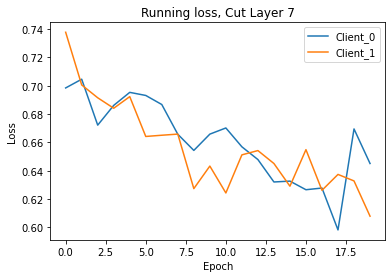

In [179]:
X = [a for a in range(epochs)]
plot_graph(X, y_s = epoch_losses)

In [180]:
# X = [a for a in range(epochs)]
# y_s = [[] for _ in range(num_clients)]
# y_s[0] = [0.7 - i*i*0.0005 for i in range(epochs)]
# y_s[1] = [0.7 - i*0.005 for i in range(epochs)]
# plot_graph(X, y_s)

## Save Model

In [181]:
model_PATH = '/content/drive/MyDrive/Drive f20190077/4-2/0_Split/Model_Weights/ResNet_S/' 
model_PATH = model_PATH + "_Cut_Layer_" + str(cut_layer) + "_" + str(train_images) + "_images_" + str(epochs) + "_epochs_"
print(model_PATH)

/content/drive/MyDrive/Drive f20190077/4-2/0_Split/Model_Weights/ResNet_S/_Cut_Layer_7_1000_images_20_epochs_


In [182]:
for c in range(num_clients):
  torch.save(client_model_list[c].state_dict(), model_PATH+"Client" + str(c) + ".pth")
torch.save(server_model.state_dict(), model_PATH+"Server.pth")

In [183]:
def model_loader(num_clients, model_PATH):
  client_model_list = [Client(config).to(device) for _ in range(num_clients)]
  for c in range(num_clients):
    mp = model_PATH+"Client" + str(c) + ".pth"
    print(mp)
    client_model_list[c].load_state_dict(torch.load(mp)) 

  return client_model_list

## Evaluation

In [185]:
def test_accuracy(model_PATH, testloaders):
  tic = time.time()

  client_model_list = model_loader(num_clients, model_PATH)
  server_model = Server(config).to(device) # M
  server_model.load_state_dict(torch.load(model_PATH+"Server.pth"))

  server_model.eval()
  correct = 0
  total = 0

  accuracies = []

  for c in range(num_clients):
    print()
    print("Testing client model ", c)
    client_model_list[c].eval()

    loader = trainloaders[c]

    with torch.no_grad():
      for data in loader:
        images, labels = data[0].to(device), data[1].to(device)
        outputs = server_model(client_model_list[c](images))

        _, predicted = torch.max(outputs, 1)

        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    acc = 100*correct/total
    accuracies.append(acc)
    
    print("Accuracy of the client model ", str(c), " is- ", acc, "%")
    print("___________________________________________________________")


  toc = time.time()
  t_test = toc - tic


  return accuracies, t_test

accuracies, t_test = test_accuracy(model_PATH, testloaders)

/content/drive/MyDrive/Drive f20190077/4-2/0_Split/Model_Weights/ResNet_S/_Cut_Layer_7_1000_images_20_epochs_Client0.pth
/content/drive/MyDrive/Drive f20190077/4-2/0_Split/Model_Weights/ResNet_S/_Cut_Layer_7_1000_images_20_epochs_Client1.pth

Testing client model  0
Accuracy of the client model  0  is-  70.8 %
___________________________________________________________

Testing client model  1
Accuracy of the client model  1  is-  62.5 %
___________________________________________________________


In [186]:
accuracies

[70.8, 62.5]

## Log

In [187]:
t_train_test, t_test_test = 10, 10

In [188]:
# accs_test = [98 for _ in range(num_clients)]

In [189]:
def condense(lis):
  a = lis[0]
  for b in lis[1:]:
    if b == a:
      continue
    else: return lis
  
  return a

print(condense([51 for _ in range(8)]))
print(condense([4, 6, 4, 4, 4, 4, 4]))


51
[4, 6, 4, 4, 4, 4, 4]


In [190]:
results = {"Cut Layer":[],	"Train_Images": [],	"Test_Images":[],	"Epochs":[],
        "Test_Accuracy":[], "Train_Time":[],	"Test_Time":[], "Datetime":[], "Running_Losses":[]}

results["Cut Layer"].append(cut_layer)
results["Train_Images"].append(train_images)
results["Test_Images"].append(test_images)
results["Epochs"].append(epochs)
results["Train_Time"].append(t_train)
results["Test_Time"].append(t_test)

results["Datetime"].append(dt)

results["Test_Accuracy"].append(accuracies)
results["Running_Losses"].append(epoch_losses)

print(results)
# del_last_update(result_PATH, last_n = 1)
update_results(result_PATH, d_new = results)

{'Cut Layer': [7], 'Train_Images': [1000], 'Test_Images': [200], 'Epochs': [20], 'Test_Accuracy': [[70.8, 62.5]], 'Train_Time': [1458.542067527771], 'Test_Time': [97.2598180770874], 'Datetime': ['2023-03-26 12:32:16.656874+05:30'], 'Running_Losses': [[[0.6984918415546417, 0.7046550251543522, 0.6722304876893759, 0.6861880254000425, 0.6953682210296392, 0.6931861937046051, 0.6867916584014893, 0.6657905410975218, 0.6543842293322086, 0.6658835280686617, 0.6702367551624775, 0.6569417025893927, 0.647940780967474, 0.6321078240871429, 0.6327118296176195, 0.6266330610960722, 0.6278222277760506, 0.5982604268938303, 0.6695552915334702, 0.645139042288065], [0.7378133218735456, 0.7006263677030802, 0.691546306014061, 0.6841603089123964, 0.6923614218831062, 0.6642359886318445, 0.6651034355163574, 0.6659040302038193, 0.6274172030389309, 0.6433296166360378, 0.6243574805557728, 0.6512463912367821, 0.6542771272361279, 0.6451443368569016, 0.6291272658854723, 0.654929406940937, 0.6262339912354946, 0.6374436

{'Cut Layer': [2, 2, 2, 3, 5, 7],
 'Train_Images': [20, 1000, 1000, 1000, 1000, 1000],
 'Test_Images': [4, 200, 200, 200, 200, 200],
 'Epochs': [3, 20, 20, 20, 20, 20],
 'Test_Accuracy': ['[50.0, 37.5]',
  '[63.5, 52.75]',
  '[63.5, 60.25]',
  '[69.4, 69.45]',
  '[68.7, 62.85]',
  [70.8, 62.5]],
 'Train_Time': [6.97151517868042,
  1430.4853310585022,
  1384.263931274414,
  1690.0338637828827,
  1450.431653022766,
  1458.542067527771],
 'Test_Time': [1.736494541168213,
  52.34426665306091,
  14.713698863983154,
  66.94739174842834,
  159.0284333229065,
  97.2598180770874],
 'Datetime': ['2023-03-25 23:32:35.515834+05:30',
  '2023-03-26 00:27:19.339005+05:30',
  '2023-03-26 00:27:19.339005+05:30',
  '2023-03-26 10:50:56.668505+05:30',
  '2023-03-26 12:03:54.783071+05:30',
  '2023-03-26 12:32:16.656874+05:30'],
 'Running_Losses': ['[[0.7797528505325317, 0.7306681871414185, 0.8371264338493347], [0.6711682677268982, 0.7032776474952698, 0.7335714101791382]]',
  '[[0.7263143919408321, 0.72182